<a href="https://colab.research.google.com/github/Jomatrix/Machine-Learning-based-Detection-of-Glaucoma-Disease-using-Retinal-Optic-Data/blob/main/CLAHE_%2B_SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/DS_Thesis/Glaucoma_Dataset.zip ./

In [ ]:
!unzip Glaucoma_Dataset.zip

Archive:  Glaucoma_Dataset.zip
   creating: Glaucoma_Dataset/
  inflating: Glaucoma_Dataset/001.jpg  
  inflating: Glaucoma_Dataset/002.jpg  
  inflating: Glaucoma_Dataset/003.jpg  
  inflating: Glaucoma_Dataset/004.jpg  
  inflating: Glaucoma_Dataset/005.jpg  
  inflating: Glaucoma_Dataset/006.jpg  
  inflating: Glaucoma_Dataset/007.jpg  
  inflating: Glaucoma_Dataset/008.jpg  
  inflating: Glaucoma_Dataset/009.jpg  
  inflating: Glaucoma_Dataset/010.jpg  
  inflating: Glaucoma_Dataset/011.jpg  
  inflating: Glaucoma_Dataset/012.jpg  
  inflating: Glaucoma_Dataset/013.jpg  
  inflating: Glaucoma_Dataset/014.jpg  
  inflating: Glaucoma_Dataset/015.jpg  
  inflating: Glaucoma_Dataset/016.jpg  
  inflating: Glaucoma_Dataset/017.jpg  
  inflating: Glaucoma_Dataset/018.jpg  
  inflating: Glaucoma_Dataset/019.jpg  
  inflating: Glaucoma_Dataset/020.jpg  
  inflating: Glaucoma_Dataset/021.jpg  
  inflating: Glaucoma_Dataset/022.jpg  
  inflating: Glaucoma_Dataset/023.jpg  
  inflating: Glauc

**CLAHE APPLICATION TO ALL IMAGES**

In [ ]:
import cv2
import os
import numpy as np
import random
from matplotlib import pyplot as plt


input_dir = '/content/Glaucoma_Dataset'


output_dir = '/content/processed_images'
train_dir = '/content/processed_images_train'
test_dir = '/content/processed_images_test'

# Create the directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all image files in the input directory
image_filenames = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Shuffle the images to randomize the input
random.shuffle(image_filenames)

# Split the data into training and testing sets (80% training, 20% testing)
split_ratio = 0.8
split_index = int(len(image_filenames) * split_ratio)
training_files = image_filenames[:split_index]
testing_files = image_filenames[split_index:]

processed_images = []

# Process each image file from the unzipped folder
for filename in image_filenames:
    img_path = os.path.join(input_dir, filename)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error loading image {filename}. Skipping.")
        continue

    # Convert from BGR to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Split the LAB image to different channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge the CLAHE enhanced L-channel with the a and b channels
    limg = cv2.merge((cl, a, b))

    # Convert the image from LAB color space back to BGR
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Determine the output directory based on the split
    if filename in training_files:
        output_path = os.path.join(train_dir, filename)
    else:
        output_path = os.path.join(test_dir, filename)

    # Save the processed image
    cv2.imwrite(output_path, final_img)
    processed_images.append((filename, img, final_img))




**DISPLAY 10 RANDOM IMAGES FOR CLAHE IMAGE TO ORIGINAL IMAGE COMPARISON**

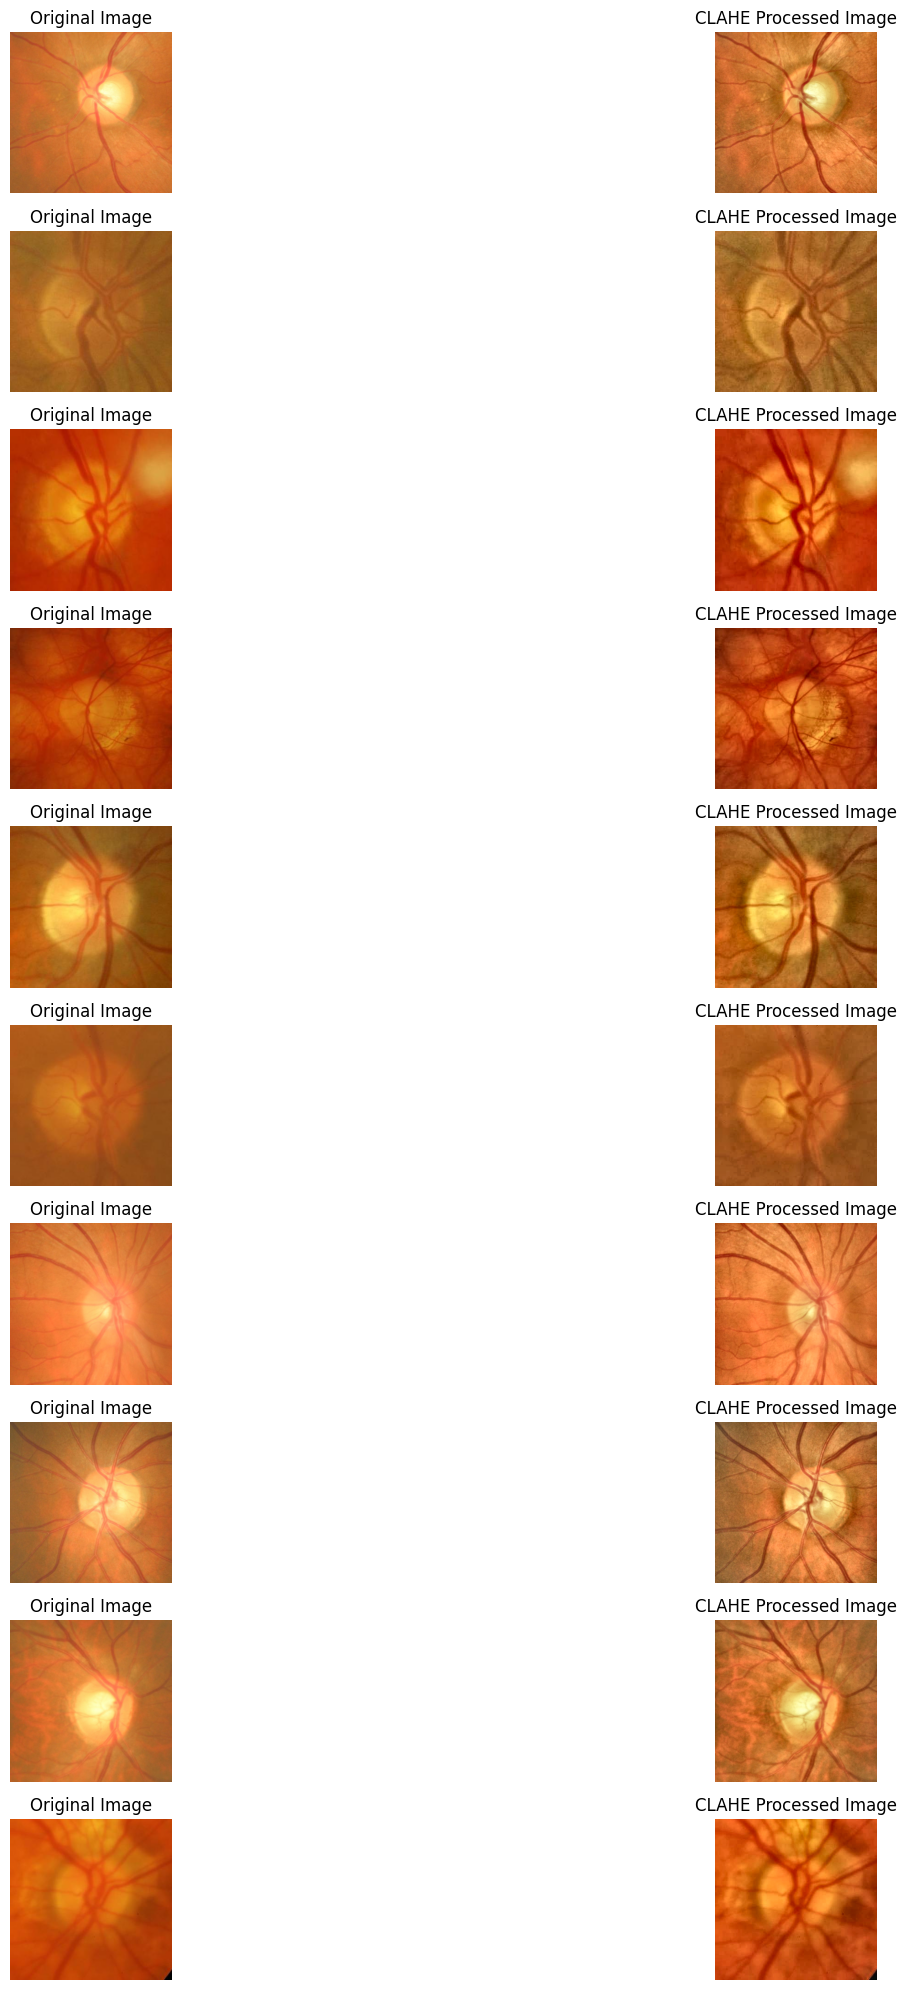

In [ ]:
# Select 10 random images for display
random_images = random.sample(processed_images, min(10, len(processed_images)))

# Display the selected images side-by-side
plt.figure(figsize=(20, 20))

for i, (filename, original, processed) in enumerate(random_images):
    # Original image
    plt.subplot(10, 2, 2 * i + 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Processed image
    plt.subplot(10, 2, 2 * i + 2)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    plt.title('CLAHE Processed Image')
    plt.axis('off')

# Show all images
plt.tight_layout()
plt.show()

**SRCNN APPLICATION TO IMAGES**

In [ ]:
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
from skimage.metrics import structural_similarity as ssim

print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(np.__version__))
print('Pandas: {}'.format(pd.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('Tensorflow: {}'.format(tf.__version__))
print('Matplotlib: {}'.format(mpl.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

def psnr(target, ref):
    mse_value = mse(target, ref)
    if mse_value == 0:  # MSE is zero means no noise is present in the signal.
        return 100
    return 20 * np.log10(255.0 / np.sqrt(mse_value))

# Define function for mean squared error (MSE)
def mse(imageA, imageB):
    err = np.sum((imageA.astype(float) - imageB.astype(float)) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

# Define function that combines all three image quality metrics
def compare_images(target, ref):
    # Convert images to grayscale if they are in color
    if len(target.shape) == 3:
        target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    if len(ref.shape) == 3:
        ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)

    psnr_value = psnr(target, ref)
    mse_value = mse(target, ref)
    ssim_value, _ = ssim(target, ref, full=True)
    return psnr_value, mse_value, ssim_value

def prepare_images(path, factor):

    # Define the directory where you want to save the processed images
    save_path = '/content/resized'

    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        print(f"Directory '{save_path}' created.")

    # Loop through the files in the directory
    for file in os.listdir(path):
        # open the file
        img = cv2.imread(os.path.join(path, file))

        if img is None:
            print(f"Failed to load image {file}. Skipping.")
            continue

        # Find old and new image dimensions
        h, w, c = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)

        # Resize down the image
        img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

        # Resize up the image
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)

         # save the image
        save_file_path = os.path.join('/content/resized', file)  # Update save path if necessary
        print(f'Saving {file} to {save_file_path}')
        cv2.imwrite(save_file_path, img)

Python: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
Numpy: 1.26.4
Pandas: 2.2.2
OpenCV: 4.10.0
Tensorflow: 2.17.0
Matplotlib: 3.8.0
Scikit-Image: 0.24.0


In [ ]:
prepare_images('/content/processed_images_test', 3)

Directory '/content/resized' created.
Saving Im098_ACRIMA.jpg to /content/resized/Im098_ACRIMA.jpg
Saving 061.jpg to /content/resized/061.jpg
Saving SHMC_130.jpg to /content/resized/SHMC_130.jpg
Saving 439_g.jpg to /content/resized/439_g.jpg
Saving SHMC_106.jpg to /content/resized/SHMC_106.jpg
Saving 647_g.jpg to /content/resized/647_g.jpg
Saving Im388_g_ACRIMA.jpg to /content/resized/Im388_g_ACRIMA.jpg
Saving Im052_ACRIMA.jpg to /content/resized/Im052_ACRIMA.jpg
Saving 216.jpg to /content/resized/216.jpg
Saving SHMC_129.jpg to /content/resized/SHMC_129.jpg
Saving 357.jpg to /content/resized/357.jpg
Saving 244.jpg to /content/resized/244.jpg
Saving 503.jpg to /content/resized/503.jpg
Saving Im379_g_ACRIMA.jpg to /content/resized/Im379_g_ACRIMA.jpg
Saving Im499_g_ACRIMA.jpg to /content/resized/Im499_g_ACRIMA.jpg
Saving Im233_ACRIMA.jpg to /content/resized/Im233_ACRIMA.jpg
Saving 174.jpg to /content/resized/174.jpg
Saving 035.jpg to /content/resized/035.jpg
Saving SHMC_72.jpg to /content

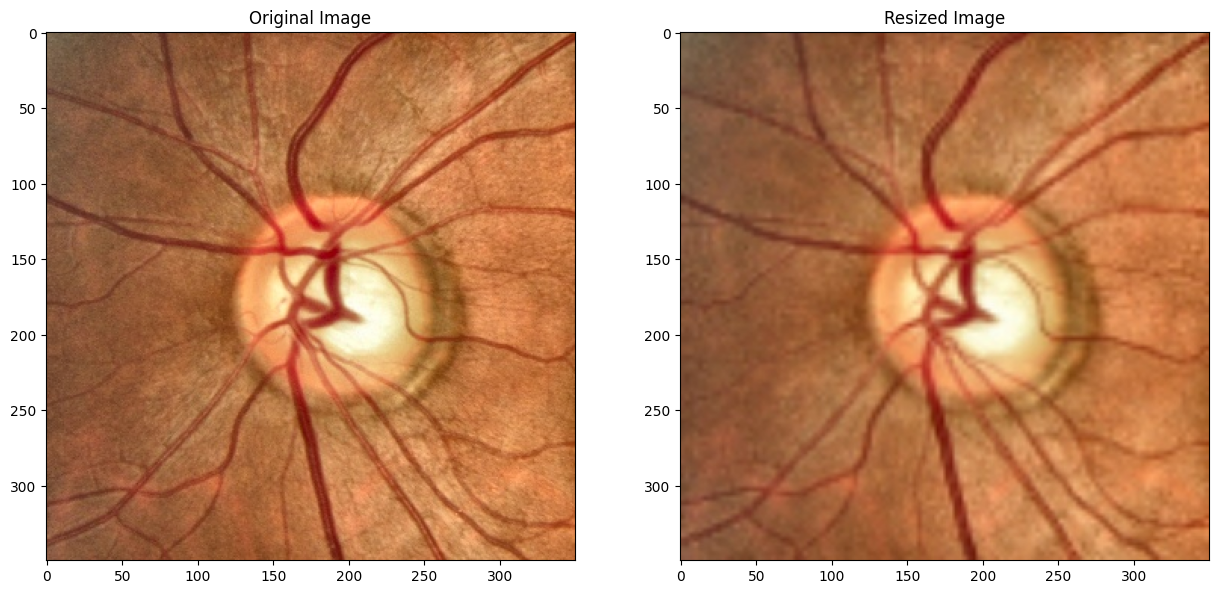

In [ ]:
from PIL import Image
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(Image.open('/content/processed_images_test/005.jpg'))
ax[0].title.set_text('Original Image')
ax[1].imshow(Image.open('/content/resized/005.jpg'))
ax[1].title.set_text('Resized Image')
plt.show()

**RESULTS OF IMAGE DEGRADATION**

In [ ]:
target = cv2.imread('/content/processed_images_test/005.jpg')
ref = cv2.imread('/content/resized/005.jpg')

metrics = compare_images(target, ref)
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

PSNR: 30.767748089394743
MSE: 54.48858775510204
SSIM: 0.7711834122844544


In [ ]:
import h5py

names = sorted(os.listdir('/content/processed_images_train'))

data = []
label = []

for name in names:
    fpath = '/content/processed_images_train/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape

    # resize operation to produce training data and labels
    lr_img = cv2.resize(hr_img, (int(shape[1] / 2), int(shape[0] / 2)))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

    width_range = int((shape[0] - 16 * 2) / 16)
    height_range = int((shape[1] - 16 * 2) / 16)

    for k in range(width_range):
        for j in range(height_range):
            x = k * 16
            y = j * 16

            hr_patch = hr_img[x: x + 32, y: y + 32]
            lr_patch = lr_img[x: x + 32, y: y + 32]

            hr_patch = hr_patch.astype(np.float32) / 255.
            lr_patch = lr_patch.astype(np.float32) / 255.

            hr = np.zeros((1, 20, 20), dtype=np.double)
            lr = np.zeros((1, 32, 32), dtype=np.double)

            hr[0, :, :] = hr_patch[6:-6, 6: -6]
            lr[0, :, :] = lr_patch

            label.append(hr)
            data.append(lr)

data = np.array(data, dtype=np.float32)
label = np.array(label, dtype=np.float32)

In [ ]:
with h5py.File('train.h5', 'w') as h:
    h.create_dataset('data', data=data, shape=data.shape)
    h.create_dataset('label', data=label, shape=label.shape)

In [ ]:
# Build test dataset

names = sorted(os.listdir('/content/processed_images_test'))
nums = len(names)

data_test = np.zeros((nums * 30, 1, 32, 32), dtype=np.double)
label_test = np.zeros((nums * 30, 1, 20, 20), dtype=np.double)

for i, name in enumerate(names):
    fpath = '/content/processed_images_test/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape

    # resize operation to produce training data and labels
    lr_img = cv2.resize(hr_img, (int(shape[1] / 2), int(shape[0] / 2)))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

    # Produce random crop
    x = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
    y = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)

    for j in range(30):
        lr_patch = lr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]
        hr_patch = hr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]

        lr_patch = lr_patch.astype(np.float32) / 255.
        hr_patch = hr_patch.astype(np.float32) / 255.

        data_test[i * 30 + j, 0, :, :] = lr_patch
        label_test[i * 30 + j, 0, :, :] = hr_patch[6: -6, 6: -6]

In [ ]:
with h5py.File('test.h5', 'w') as h:
    h.create_dataset('data', data=data_test, shape=data_test.shape)
    h.create_dataset('label', data=label_test, shape=label_test.shape)

In [ ]:
# Define the SR-CNN model
def model():
    SRCNN = tf.keras.Sequential(name='SRCNN')
    SRCNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(9, 9),
                                     padding='VALID',
                                     use_bias=True,
                                     input_shape=(None, None, 1),
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                     padding='SAME',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(5, 5),
                                     padding='VALID',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='linear'))
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

    # Compile model
    SRCNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

    return SRCNN

In [ ]:
srcnn_model = model()
srcnn_model.summary()

Model: "SRCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, None, None, 128)     │          10,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, None, None, 64)      │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, None, None, 1)       │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,889 (335.50 KB)

 Trainable params: 85,889 (335.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
with h5py.File('./train.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train = np.transpose(data, (0, 2, 3, 1))
    y_train = np.transpose(label, (0, 2, 3, 1))

with h5py.File('./test.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test = np.transpose(data, (0, 2, 3, 1))
    y_test = np.transpose(label, (0, 2, 3, 1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((463524, 32, 32, 1),
 (463524, 20, 20, 1),
 (9630, 32, 32, 1),
 (9630, 20, 20, 1))

In [ ]:
checkpoint_path = './srcnn/cp-{epoch:04d}.ckpt'
checkpoint_path = './srcnn/cp-{epoch:04d}.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
os.makedirs(checkpoint_dir, exist_ok=True)

# Set up the checkpoint callback to save only the best model's weights
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,  # PATH for checkpoint
    save_best_only=True,
    save_weights_only=True,  #
    verbose=1
)

In [ ]:
# Assuming your checkpoint file is named 'model_checkpoint.h5'
srcnn_model.load_weights('/content/cp-0093.weights.h5')

# Resume training
srcnn_model.fit(X_train, y_train, batch_size=16, validation_data=(X_test, y_test),
                callbacks=[checkpoint], shuffle=True, epochs=0, verbose=False)

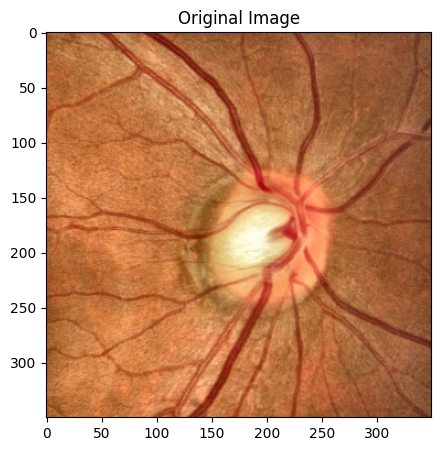

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(Image.open('/content/processed_images_test/004.jpg'))
ax.title.set_text("Original Image")
plt.show()

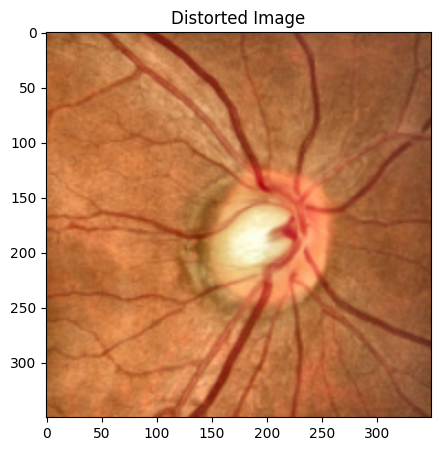

In [ ]:
# Make output directory
try:
    os.listdir('/content/output')
except:
    os.mkdir('/content/output')

target = cv2.imread('/content/processed_images_test/004.jpg', cv2.IMREAD_COLOR)
target = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
shape = target.shape

# Resize down by scale of 2
Y_img = cv2.resize(target[:, :, 0], (int(shape[1] / 2), int(shape[0] / 2)), cv2.INTER_CUBIC)

# Resize up to orignal image
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
target[:, :, 0] = Y_img
target = cv2.cvtColor(target, cv2.COLOR_YCrCb2BGR)
cv2.imwrite('/content/output/input.jpg', target)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(Image.open('/content/output/input.jpg'))
ax.title.set_text("Distorted Image")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


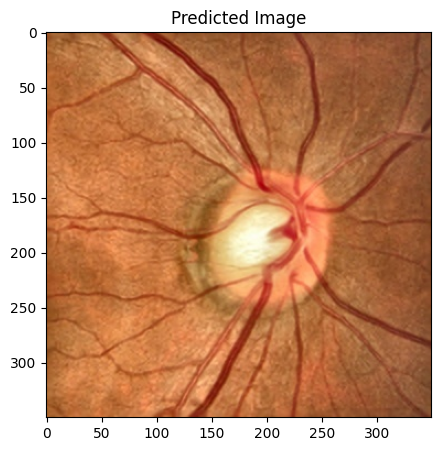

In [ ]:
Y = np.zeros((1, target.shape[0], target.shape[1], 1), dtype=np.float32)
# Normalize
Y[0, :, :, 0] = Y_img.astype(np.float32) / 255.

# Predict
pre = srcnn_model.predict(Y, batch_size=1) * 255.

# Post process output
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)

# Copy y channel back to image and convert to BGR
output = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
output[6: -6, 6: -6, 0] = pre[0, :, :, 0]
output = cv2.cvtColor(output, cv2.COLOR_YCrCb2BGR)

# Save image
cv2.imwrite('/content/output/output.jpg', output)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(Image.open('/content/output/output.jpg'))
ax.title.set_text("Predicted Image")
plt.show()

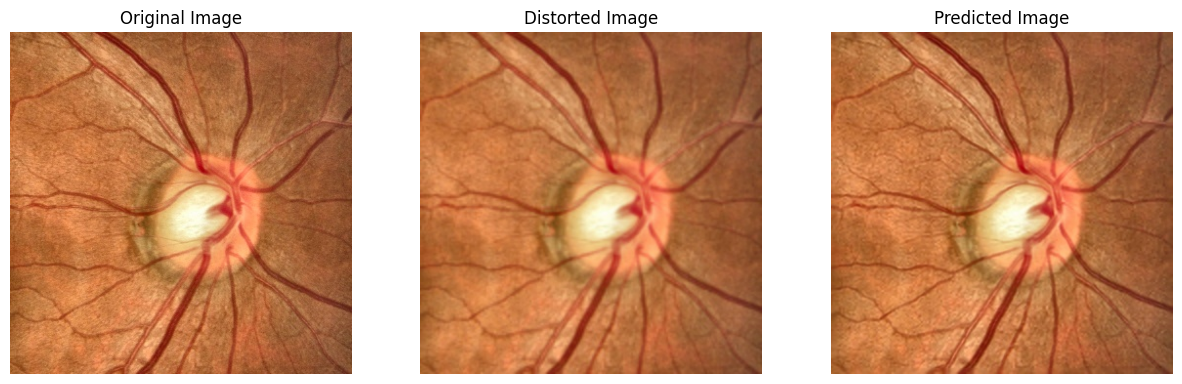

In [ ]:
# Load images
original_image = Image.open('/content/processed_images_test/004.jpg')
distorted_image = Image.open('/content/output/input.jpg')
predicted_image = Image.open('/content/output/output.jpg')

# Display images side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(distorted_image)
axes[1].set_title("Distorted Image")
axes[1].axis("off")

axes[2].imshow(predicted_image)
axes[2].set_title("Predicted Image")
axes[2].axis("off")

plt.show()

In [ ]:
original = cv2.imread('/content/processed_images_test/004.jpg')
distorted = cv2.imread('/content/output/input.jpg')
predicted = cv2.imread('/content/output/output.jpg')

# Comparing original and distorted image
metrics = compare_images(original, distorted)
print("Metrics for original and distorted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

# Comparing original and predicted image
metrics = compare_images(original, predicted)
print("\n\nMetrics for original and predicted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and distorted image
PSNR: 32.309810827911186
MSE: 38.20315918367347
SSIM: 0.8269944811864837


Metrics for original and predicted image
PSNR: 33.89485719806776
MSE: 26.521289795918367
SSIM: 0.8803486186567671


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


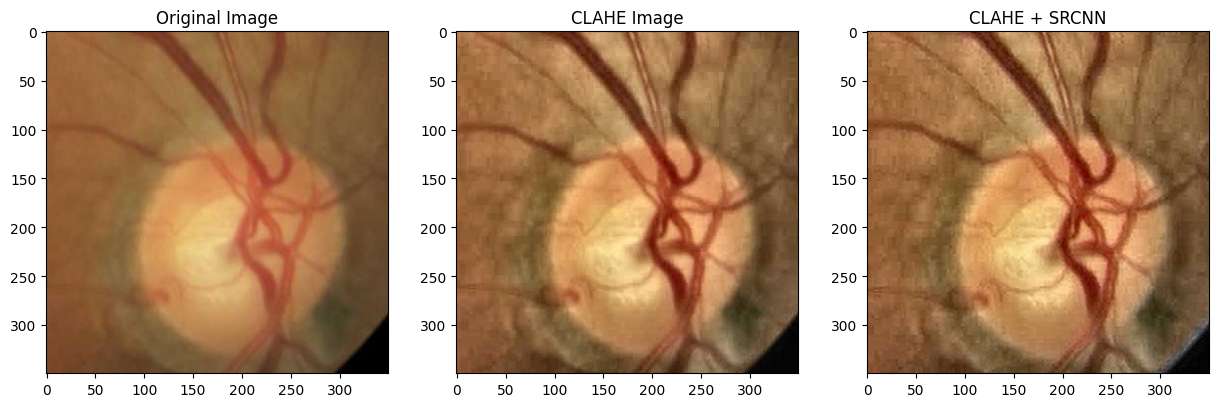

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Make output directory
try:
    os.listdir('/content/output')
except:
    os.mkdir('/content/output')

# Read the target image
target = cv2.imread('/content/processed_images_test/SHMC_14.jpg', cv2.IMREAD_COLOR)

# Convert the image to YCrCb color space
target_YCrCb = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)

# Extract the Y (luminance) channel
Y_img = target_YCrCb[:, :, 0].astype(np.float32) / 255.  # Normalize Y channel

# Prepare input for the SRCNN model
Y = np.zeros((1, target.shape[0], target.shape[1], 1), dtype=np.float32)
Y[0, :, :, 0] = Y_img

# Predict the high-resolution Y channel using the SRCNN model
pre = srcnn_model.predict(Y, batch_size=1) * 255.  # Scale back to [0, 255]

# Post-process the prediction
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)

# Resize the predicted Y channel to match the original image's dimensions (if needed)
pre_resized = cv2.resize(pre[0, :, :, 0], (target.shape[1], target.shape[0]))

# Replace the Y channel in the original YCrCb image with the predicted one
target_YCrCb[:, :, 0] = pre_resized

# Convert the image back to BGR color space
output = cv2.cvtColor(target_YCrCb, cv2.COLOR_YCrCb2BGR)

# Save the resulting image
cv2.imwrite('/content/output/output.jpg', output)

# Display the original and processed images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
ax[0].imshow(cv2.cvtColor(cv2.imread('/content/Glaucoma_Dataset/SHMC_14.jpg'), cv2.COLOR_BGR2RGB))
ax[0].title.set_text("Original Image")

# CLAHE Image
ax[1].imshow(cv2.cvtColor(cv2.imread('/content/processed_images_test/SHMC_14.jpg'), cv2.COLOR_BGR2RGB))
ax[1].title.set_text("CLAHE Image")

# Predicted Image
ax[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
ax[2].title.set_text("CLAHE + SRCNN")

plt.show()


**TEST SET AVERAGE RESULTS FOR ALL METRICS**

In [ ]:
import os
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse, structural_similarity as ssim
import matplotlib.pyplot as plt
from PIL import Image

# Function to compare images and calculate PSNR, MSE, SSIM
def compare_images(img1, img2):
    psnr_value = psnr(img1, img2)
    mse_value = mse(img1, img2)
    ssim_value = ssim(img1, img2, win_size=7, channel_axis=-1)  # Set win_size and channel_axis for color images
    return psnr_value, mse_value, ssim_value

# Initialize accumulators for metrics
psnr_diff_accum = 0
mse_diff_accum = 0
ssim_diff_accum = 0

num_images = 0

# Directory containing test images
test_images_dir = '/content/processed_images_test'

# List all images in the directory
image_files = os.listdir(test_images_dir)

# Loop through each image file in the directory
for image_file in image_files:
    # Load the image
    target = cv2.imread(os.path.join(test_images_dir, image_file), cv2.IMREAD_COLOR)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
    shape = target.shape

    # Resize down by a scale of 2
    Y_img = cv2.resize(target[:, :, 0], (int(shape[1] / 2), int(shape[0] / 2)), cv2.INTER_CUBIC)

    # Resize up to original size
    Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
    target[:, :, 0] = Y_img
    target = cv2.cvtColor(target, cv2.COLOR_YCrCb2BGR)

    # Save distorted image
    distorted_image_path = f'/content/output/distorted_{image_file}'
    cv2.imwrite(distorted_image_path, target)

    # Prepare for prediction
    Y = np.zeros((1, target.shape[0], target.shape[1], 1), dtype=np.float32)
    Y[0, :, :, 0] = Y_img.astype(np.float32) / 255.

    # Predict using SRCNN
    pre = srcnn_model.predict(Y, batch_size=1) * 255.

    # Post-process the predicted output
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)

    # Copy Y channel back to image and convert to BGR
    output = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
    output[6: -6, 6: -6, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(output, cv2.COLOR_YCrCb2BGR)

    # Save the predicted image
    predicted_image_path = f'/content/output/predicted_{image_file}'
    cv2.imwrite(predicted_image_path, output)

    # Load original, distorted, and predicted images
    original = cv2.imread(os.path.join(test_images_dir, image_file))
    distorted = cv2.imread(distorted_image_path)
    predicted = cv2.imread(predicted_image_path)

    # Comparing original and distorted images
    psnr_distorted, mse_distorted, ssim_distorted = compare_images(original, distorted)

    # Comparing original and predicted images
    psnr_predicted, mse_predicted, ssim_predicted = compare_images(original, predicted)

    # Accumulate improvements
    psnr_diff_accum += (psnr_predicted - psnr_distorted)
    mse_diff_accum += (mse_distorted - mse_predicted)  # For MSE, improvement is the reduction
    ssim_diff_accum += (ssim_predicted - ssim_distorted)

    num_images += 1

# Calculate the average improvements
avg_psnr_improvement = psnr_diff_accum / num_images
avg_mse_improvement = mse_diff_accum / num_images
avg_ssim_improvement = ssim_diff_accum / num_images

# Output the average improvements
print(f"Average PSNR Improvement: {avg_psnr_improvement:.4f}")
print(f"Average MSE Improvement: {avg_mse_improvement:.4f}")
print(f"Average SSIM Improvement: {avg_ssim_improvement:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [ ]:
import os
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse, structural_similarity as ssim

# Function to compare images and calculate PSNR, MSE, SSIM
def compare_images(img1, img2):
    psnr_value = psnr(img1, img2)
    mse_value = mse(img1, img2)
    ssim_value = ssim(img1, img2, win_size=7, channel_axis=-1)  # Set win_size and channel_axis for color images
    return psnr_value, mse_value, ssim_value

# Path to the output directory
output_dir = '/content/output'

# List of folders to process separately
categories = ['numeric', 'drishtiGS', 'Im', 'SHMC']

# Loop through each category folder
for category in categories:
    category_path = os.path.join(output_dir, category)
    if not os.path.exists(category_path):
        continue  # Skip if the folder doesn't exist

    # Initialize accumulators for metrics
    psnr_diff_accum = 0
    mse_diff_accum = 0
    ssim_diff_accum = 0
    num_images = 0

    # List all files in the category directory
    files = os.listdir(category_path)

    # Loop through the files and calculate metrics
    for file_name in files:
        if not (file_name.startswith("predicted_") or file_name.startswith("distorted_")):
            continue

        # Get the original filename (remove the 'predicted_' or 'distorted_' prefix)
        original_name = file_name.split('_', 1)[1]

        # File paths for original, distorted, and predicted images
        distorted_image_path = os.path.join(category_path, f'distorted_{original_name}')
        predicted_image_path = os.path.join(category_path, f'predicted_{original_name}')
        original_image_path = os.path.join('/content/processed_images_test', original_name)  # Original file path

        # Load original, distorted, and predicted images
        original = cv2.imread(original_image_path)
        distorted = cv2.imread(distorted_image_path)
        predicted = cv2.imread(predicted_image_path)

        if original is None or distorted is None or predicted is None:
            print(f"Skipping {original_name}, one or more files are missing.")
            continue  # Skip if any image is missing

        # Comparing original and distorted images
        psnr_distorted, mse_distorted, ssim_distorted = compare_images(original, distorted)

        # Comparing original and predicted images
        psnr_predicted, mse_predicted, ssim_predicted = compare_images(original, predicted)

        # Accumulate improvements
        psnr_diff_accum += (psnr_predicted - psnr_distorted)
        mse_diff_accum += (mse_distorted - mse_predicted)  # For MSE, improvement is the reduction
        ssim_diff_accum += (ssim_predicted - ssim_distorted)

        num_images += 1

    # Calculate the average improvements for this category
    if num_images > 0:
        avg_psnr_improvement = psnr_diff_accum / num_images
        avg_mse_improvement = mse_diff_accum / num_images
        avg_ssim_improvement = ssim_diff_accum / num_images

        # Output the average improvements for this category
        print(f"Category: {category}")
        print(f"Average PSNR Improvement: {avg_psnr_improvement:.4f}")
        print(f"Average MSE Improvement: {avg_mse_improvement:.4f}")
        print(f"Average SSIM Improvement: {avg_ssim_improvement:.4f}\n")
    else:
        print(f"No images processed for category: {category}\n")

Category: numeric
Average PSNR Improvement: 1.2085
Average MSE Improvement: 4.5069
Average SSIM Improvement: 0.0267

Category: drishtiGS
Average PSNR Improvement: 0.4566
Average MSE Improvement: 1.0049
Average SSIM Improvement: 0.0128

Category: Im
Average PSNR Improvement: 1.8309
Average MSE Improvement: 1.6596
Average SSIM Improvement: 0.0117

Category: SHMC
Average PSNR Improvement: 1.2581
Average MSE Improvement: 1.8062
Average SSIM Improvement: 0.0101



==========================================

In [ ]:
import os
import shutil

# Path to the output directory
output_dir = '/content/output'

# Create directories for each category
categories = ['numeric', 'drishtiGS', 'Im', 'SHMC']
for category in categories:
    os.makedirs(os.path.join(output_dir, category), exist_ok=True)

# List all files in the output directory
files = os.listdir(output_dir)

# Function to move files to appropriate directories
def move_file(file_name, category):
    source = os.path.join(output_dir, file_name)
    destination = os.path.join(output_dir, category, file_name)
    shutil.move(source, destination)

# Loop through files and move them based on their name format
for file_name in files:
    # Ignore non-image files (like directories)
    if not (file_name.startswith("predicted_") or file_name.startswith("distorted_")):
        continue

    # Remove the "predicted_" or "distorted_" prefix to get the original filename
    original_name = file_name.split('_', 1)[1]  # Split only at the first occurrence of '_'

    # Separate based on the original filename prefix
    if original_name[0].isdigit():  # Category 1: Filename starts with a number (e.g., 001.jpg)
        move_file(file_name, 'numeric')
    elif original_name.startswith('drishtiGS'):  # Category 2: drishtiGS
        move_file(file_name, 'drishtiGS')
    elif original_name.startswith('Im'):  # Category 3: Im
        move_file(file_name, 'Im')
    elif original_name.startswith('SHMC'):  # Category 4: SHMC
        move_file(file_name, 'SHMC')

**APPLYING SRCNN TO ALL IMAGES**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
Processed SHMC_39.jpg and saved to /content/output/SHMC_39.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
Processed Im537_g_ACRIMA.jpg and saved to /content/output/Im537_g_ACRIMA.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
Processed SHMC_151.jpg and saved to /content/output/SHMC_151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
Processed Im484_g_ACRIMA.jpg and saved to /content/output/Im484_g_ACRIMA.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
Processed 321.jpg and saved to /content/output/321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
Processed 249.jpg and saved to /content/output/249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Processed 136.jpg and saved to /content/output/136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
Processed 501.jpg and saved to /content/output/501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
Processed 603.jpg and saved to /content/output/603.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
Processed Im349_g_ACRIMA.jpg and saved to /content/ou

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


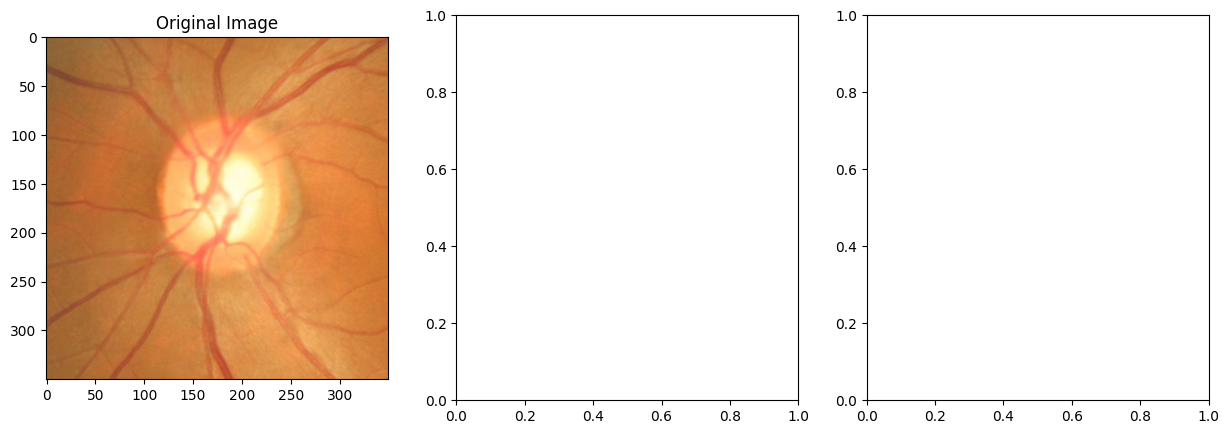

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Make output directory
output_dir = '/content/output'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# Function to apply SRCNN on an image
def apply_srcnn_to_image(image_path, output_path):
    # Read the target image
    target = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert the image to YCrCb color space
    target_YCrCb = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)

    # Extract the Y (luminance) channel
    Y_img = target_YCrCb[:, :, 0].astype(np.float32) / 255.  # Normalize Y channel

    # Prepare input for the SRCNN model
    Y = np.zeros((1, target.shape[0], target.shape[1], 1), dtype=np.float32)
    Y[0, :, :, 0] = Y_img

    # Predict the high-resolution Y channel using the SRCNN model
    pre = srcnn_model.predict(Y, batch_size=1) * 255.  # Scale back to [0, 255]

    # Post-process the prediction
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)

    # Resize the predicted Y channel to match the original image's dimensions (if needed)
    pre_resized = cv2.resize(pre[0, :, :, 0], (target.shape[1], target.shape[0]))

    # Replace the Y channel in the original YCrCb image with the predicted one
    target_YCrCb[:, :, 0] = pre_resized

    # Convert the image back to BGR color space
    output = cv2.cvtColor(target_YCrCb, cv2.COLOR_YCrCb2BGR)

    # Save the resulting image
    cv2.imwrite(output_path, output)

# Directories to process
directories = ['/content/processed_images_test', '/content/processed_images_train']

# Loop through each directory and process the images
for directory in directories:
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Process only image files
            image_path = os.path.join(directory, filename)
            output_path = os.path.join(output_dir, filename)

            # Apply SRCNN and save the result
            apply_srcnn_to_image(image_path, output_path)

            print(f"Processed {filename} and saved to {output_path}")


fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
ax[0].imshow(cv2.cvtColor(cv2.imread('/content/Glaucoma_Dataset/002.jpg'), cv2.COLOR_BGR2RGB))
ax[0].title.set_text("Original Image")

# CLAHE Image
ax[1].imshow(cv2.cvtColor(cv2.imread('/content/processed_images_test/002.jpg'), cv2.COLOR_BGR2RGB))
ax[1].title.set_text("CLAHE Image")

# Predicted Image
ax[2].imshow(cv2.cvtColor(cv2.imread('/content/output/002.jpg'), cv2.COLOR_BGR2RGB))
ax[2].title.set_text("CLAHE + SRCNN")

plt.show()

**DOWNLOAD THE IMAGES TO BE USED FOR TRAINING SEGMENTATION MODEL**

In [ ]:
import shutil
from google.colab import files

# Compress the folder
shutil.make_archive('/content/output', 'zip', '/content/output')

# Download the zip file
files.download('/content/output.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
shutil.rmtree('/content/output')

In [ ]:
os.mkdir('/content/output')